In [1]:
################################################################################################################################
#
# LSTM - JANSEN - FRACDIFF - LN - MONTHLY
#
################################################################################################################################

#-------------------------------------------------------------------------------------------------------------------------------
# 
#-------------------------------------------------------------------------------------------------------------------------------

#===============================================================================================================================
# ENVIRONMENT: LIBRARIES, SETTINGS
#===============================================================================================================================
#pip install pandas-datareader

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import sklearn
import sklearn.preprocessing
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation
from tensorflow import keras

In [2]:
#===============================================================================================================================
# ENVIRONMENT: HARDWARE
#===============================================================================================================================
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [3]:
#===============================================================================================================================
# ENVIRONMENT: CONFIG
#===============================================================================================================================
sns.set_style('whitegrid')
np.random.seed(42)

In [4]:
#===============================================================================================================================
# DATA: INPUT/OUTPUT
#===============================================================================================================================
input_path = Path('Data', 'Input')
results_path = Path('Data\Output', 'Jansen-LSTM-FracDiff-Ln-Monthly')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [5]:
#===============================================================================================================================
# DATA: SETTINGS
#===============================================================================================================================
seriesId='IBOV-FracDiff-Ln-Monthly'
#ESCALA = 'log'  #'minmax' 
#EPOCAS = 100
#LOTE = 12
#NEURONS = 32
window_size=6

In [11]:
#===============================================================================================================================
# DATA: READ - FFD
#===============================================================================================================================
df = pd.read_csv('Data/Input/'+seriesId+'.csv')
#df['Date']= pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)
df

,Close
Date,
2006-01-31,3.917126
2006-02-24,3.881832
2006-03-31,3.842665
2006-04-28,3.892926
2006-05-31,3.770014
...,...
2023-08-31,4.087320
2023-09-29,4.097383
2023-10-31,4.065104


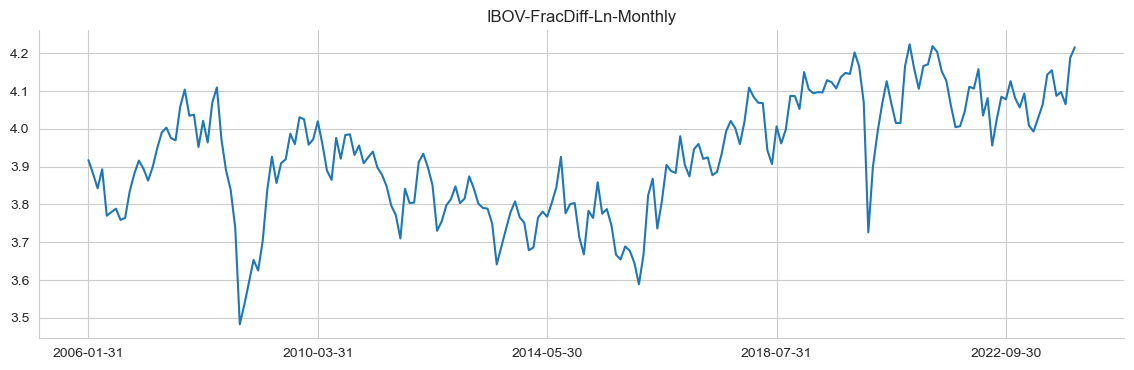

In [12]:
#===============================================================================================================================
# DATA: PLOT
#===============================================================================================================================
ax = df.plot(title=seriesId, legend=False, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [13]:
#===============================================================================================================================
# DATA: SCALE - DESCRIPTION
#===============================================================================================================================
df_scaled = df.copy()
#df_scaled['Close'] = np.log(df_scaled['Close'])

print(df_scaled.describe())
df_scaled

            Close
count  216.000000
mean     3.928016
std      0.153735
min      3.482940
25%      3.804260
50%      3.928491
75%      4.058968
max      4.223667


,Close
Date,
2006-01-31,3.917126
2006-02-24,3.881832
2006-03-31,3.842665
2006-04-28,3.892926
2006-05-31,3.770014
...,...
2023-08-31,4.087320
2023-09-29,4.097383
2023-10-31,4.065104


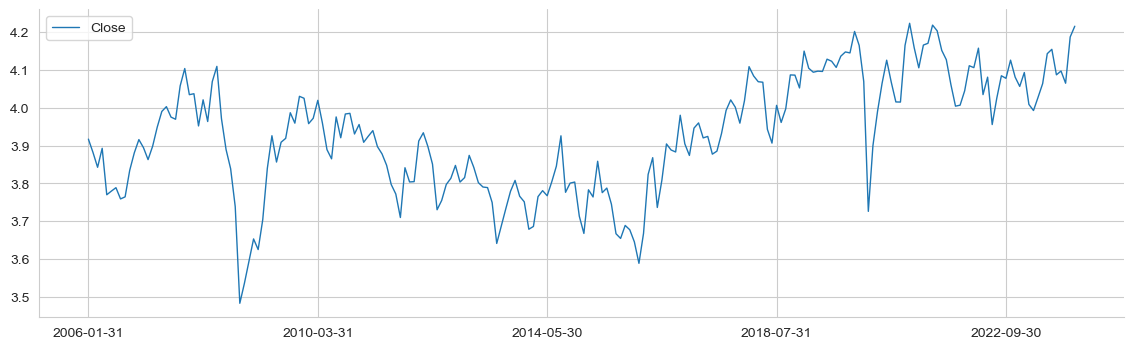

In [14]:
#===============================================================================================================================
# DATA: PLOT
#===============================================================================================================================
ax = df_scaled.plot(lw=1, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [15]:
#===============================================================================================================================
# DATA PREP: RECURRENT SEQUENCES - FUNCTION
#===============================================================================================================================
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    #y = data[window_size-1:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    #X = np.hstack(tuple([data[i: n-j+1, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

In [16]:
#===============================================================================================================================
# DATA PREP: RECURRENT SEQUENCES - RUN
#===============================================================================================================================
X, y = create_univariate_rnn_data(df_scaled, window_size=window_size)
X


,0,1,2,3,4,5
Date,,,,,,
2006-07-31,3.917126,3.881832,3.842665,3.892926,3.770014,3.779638
2006-08-31,3.881832,3.842665,3.892926,3.770014,3.779638,3.788772
2006-09-29,3.842665,3.892926,3.770014,3.779638,3.788772,3.759013
2006-10-31,3.892926,3.770014,3.779638,3.788772,3.759013,3.764472
2006-11-30,3.770014,3.779638,3.788772,3.759013,3.764472,3.834565
...,...,...,...,...,...,...
2023-08-31,4.009027,3.992839,4.028022,4.064120,4.143223,4.154807
2023-09-29,3.992839,4.028022,4.064120,4.143223,4.154807,4.087320
2023-10-31,4.028022,4.064120,4.143223,4.154807,4.087320,4.097383


In [17]:
#===============================================================================================================================
# DATA PREP: SPLIT
#===============================================================================================================================
X_train = X[:'2023'].values.reshape(-1, window_size, 1)
y_train = y[:'2023']

In [18]:
#===============================================================================================================================
# DATA PREP: RECURRENT SEQUENCES - RUN - TEST
#===============================================================================================================================
X_test = X['2023':].values.reshape(-1, window_size, 1)
y_test = y['2023':]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(198, 6, 1) (198, 1) (12, 6, 1) (12, 1)


In [19]:
#===============================================================================================================================
# DATA PREP: OBS, WINDOWS, FEATURES
#===============================================================================================================================
n_obs, window_size, n_features = X_train.shape
n_obs, window_size, n_features

(198, 6, 1)

In [20]:
#===============================================================================================================================
# MODEL: LSTM
#===============================================================================================================================
rnn = Sequential([
    LSTM(units=10, input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

rnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 10)                480       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
#===============================================================================================================================
# MODEL: CONFIG
#===============================================================================================================================
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, weight_decay=0.0)

rnn.compile(loss='mean_squared_error', optimizer=optimizer)

rnn_path = (results_path / 'Jansen-FracDiff-Ln-Monthly-rnn.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=rnn_path, verbose=1, monitor='val_loss', save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [22]:
#===============================================================================================================================
# MODEL: TRAIN
#===============================================================================================================================
lstm_training = rnn.fit(X_train, y_train, epochs=150, batch_size=20, shuffle=True, 
                        validation_data=(X_test, y_test), 
                        callbacks=[early_stopping, checkpointer],verbose=1)

Epoch 1/150

 1/10 [==>...........................] - ETA: 22s - loss: 19.3929
Epoch 1: val_loss improved from inf to 17.91256, saving model to Data/Output/Jansen-LSTM-FracDiff-Ln-Monthly\Jansen-FracDiff-Ln-Monthly-rnn.h5
10/10 [==============================] - 3s 83ms/step - loss: 17.8470 - val_loss: 17.9126
Epoch 2/150
 1/10 [==>...........................] - ETA: 0s - loss: 16.2870
Epoch 2: val_loss improved from 17.91256 to 16.22275, saving model to Data/Output/Jansen-LSTM-FracDiff-Ln-Monthly\Jansen-FracDiff-Ln-Monthly-rnn.h5
10/10 [==============================] - 0s 10ms/step - loss: 15.7356 - val_loss: 16.2227
Epoch 3/150
 1/10 [==>...........................] - ETA: 0s - loss: 14.5118
Epoch 3: val_loss improved from 16.22275 to 14.83890, saving model to Data/Output/Jansen-LSTM-FracDiff-Ln-Monthly\Jansen-FracDiff-Ln-Monthly-rnn.h5
10/10 [==============================] - 0s 11ms/step - loss: 14.2649 - val_loss: 14.8389
Epoch 4/150
 1/10 [==>...........................] - ETA: 

10/10 [==============================] - 0s 11ms/step - loss: 0.0242 - val_loss: 0.0363
Epoch 27/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.0236
Epoch 27: val_loss did not improve from 0.03626
10/10 [==============================] - 0s 11ms/step - loss: 0.0240 - val_loss: 0.0412
Epoch 28/150
 1/10 [==>...........................] - ETA: 0s - loss: 0.0266
Epoch 28: val_loss improved from 0.03626 to 0.02890, saving model to Data/Output/Jansen-LSTM-FracDiff-Ln-Monthly\Jansen-FracDiff-Ln-Monthly-rnn.h5
10/10 [==============================] - 0s 9ms/step - loss: 0.0235 - val_loss: 0.0289
Epoch 29/150
 1/10 [==>...........................] - ETA: 0s - loss: 0.0301
Epoch 29: val_loss did not improve from 0.02890
10/10 [==============================] - 0s 7ms/step - loss: 0.0238 - val_loss: 0.0402
Epoch 30/150
 1/10 [==>...........................] - ETA: 0s - loss: 0.0205
Epoch 30: val_loss did not improve from 0.02890
10/10 [==============================] - 0s 8ms/ste

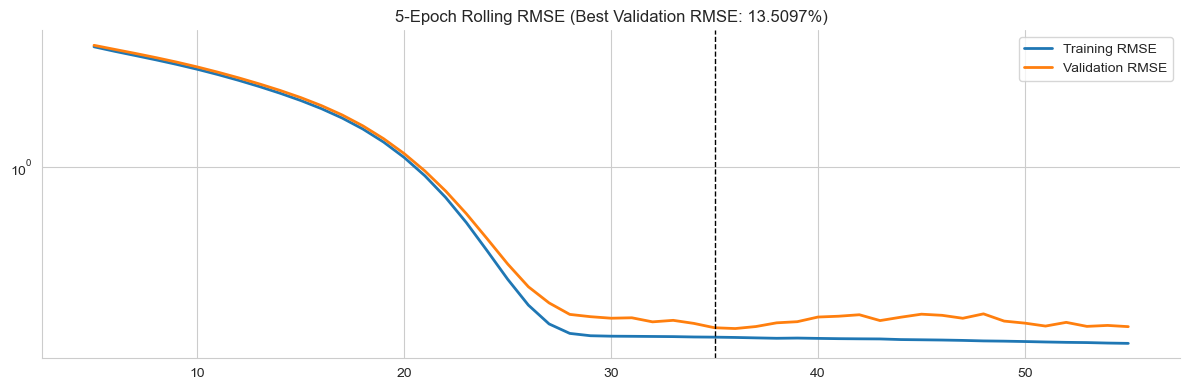

In [23]:
#===============================================================================================================================
# RESULTS - PERFORMANCE vs EPOCHS - TRAIN, VALIDATION
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_error', dpi=300);

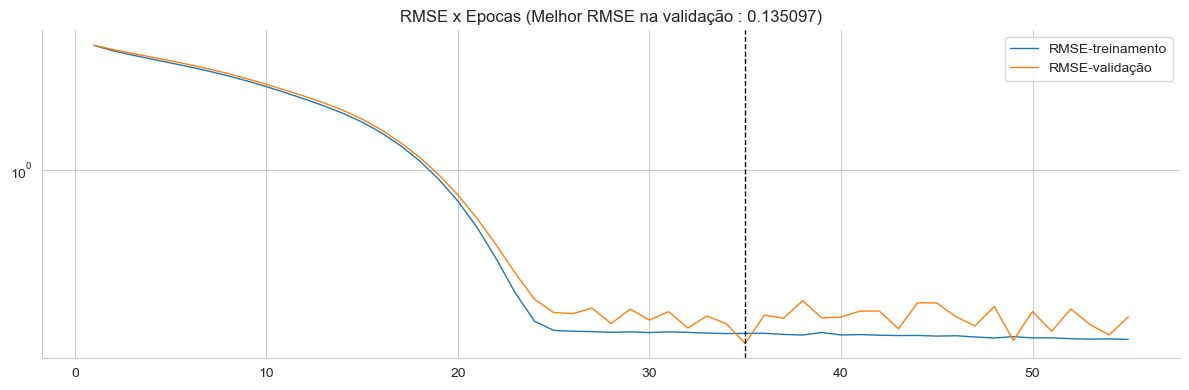

In [24]:
#===============================================================================================================================
# RESULTS - PERFORMANCE vs EPOCHS - TRAIN, VALIDATION
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'RMSE x Epocas (Melhor RMSE na validação : {best_rmse:.6})'
loss_history.columns=['RMSE-treinamento', 'RMSE-validação']
loss_history.rolling(1).mean().plot(logy=True, lw=1, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_error', dpi=300);

In [25]:
#===============================================================================================================================
# RESULTS - PERFORMANCE - TRAIN, TEST
#===============================================================================================================================
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Train RMSE: 0.0911 | Test RMSE: 0.0990
#-------------------------------------------------------------------------------------------------------------------------------

Train RMSE: 0.1588 | Test RMSE: 0.1351


In [26]:
#===============================================================================================================================
# RESULTS - FORECAST - TRAIN, TEST
#===============================================================================================================================
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

1/1 [==============================] - 0s 17ms/step


In [27]:
#===============================================================================================================================
# RESULTS - SPEARMAN IC - TRAIN, TEST
#===============================================================================================================================
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.6f} | Test IC: {test_ic:.4f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Train IC: 0.851309 | Test IC: 0.3497
#-------------------------------------------------------------------------------------------------------------------------------

Train IC: 0.874447 | Test IC: 0.5385


In [28]:
#===============================================================================================================================
# RESULTS - FORECAST - RESULTS - TEST
#===============================================================================================================================
np.savetxt('Data/Output/LSTM-Jansen-FracDiff-Ln-Monthly-Train.txt', train_predict_scaled, delimiter=';')
np.savetxt('Data/Output/LSTM-Jansen-FracDiff-Ln-Monthly-Test.txt' , test_predict_scaled, delimiter=';')
test_predict_scaled[:,0]

array([3.9769635, 3.977243 , 3.9770386, 3.9764817, 3.9763112, 3.9767814,
       3.9776955, 3.9778945, 3.9775429, 3.9771821, 3.9772809, 3.9780717],
      dtype=float32)

In [29]:
#===============================================================================================================================
# FRACDIFF: RECOVER - PRICES - d, THRESHOLD
#===============================================================================================================================
d=0.2085
THRESHOLD=1e-3

In [30]:
#===============================================================================================================================
# FRACDIFF: RECOVER - FUNCTION WEIGHTS
#===============================================================================================================================
def getWeights_FFD(d, thres=THRESHOLD, lim=10000):
    w, k = [1.], 1                          # Set w as a list and k as one
    ctr = 0                                 # Set ctr
    while True:                             # Loop While
        w_ = -w[-1] / k * (d - k + 1)          # Create the new weight value
        if abs(w_) < thres:break               # End the loop in case the threshold is breached
        w.append(w_)                           # Append the new value of w
        k += 1                                 # Increment k
        ctr += 1                               # Increment ctr
        if ctr == lim - 1:break                # End the loop in case it breaches the limit
    return np.array(w[::-1]).reshape(-1, 1) # Convert the w from list to a numpy array

In [31]:
#===============================================================================================================================
# FRACDIFF: RECOVER - WEIGHTS
#===============================================================================================================================
#w_FFD = getWeights_FFD(d, thres=1e-6, lim=5942-428+2)
w_FFD = getWeights_FFD(d, thres=1e-3, lim=248)
print(len(w_FFD[:-1]))
w_FFD[:]

72


array([[-0.00101308],
       [-0.00103038],
       [-0.00104822],
       [-0.00106663],
       [-0.00108565],
       [-0.00110529],
       [-0.00112559],
       [-0.00114659],
       [-0.00116831],
       [-0.0011908 ],
       [-0.00121409],
       [-0.00123822],
       [-0.00126325],
       [-0.00128921],
       [-0.00131617],
       [-0.00134418],
       [-0.0013733 ],
       [-0.00140359],
       [-0.00143512],
       [-0.00146797],
       [-0.00150223],
       [-0.00153797],
       [-0.0015753 ],
       [-0.00161432],
       [-0.00165514],
       [-0.00169789],
       [-0.0017427 ],
       [-0.00178971],
       [-0.0018391 ],
       [-0.00189104],
       [-0.00194573],
       [-0.00200337],
       [-0.00206422],
       [-0.00212852],
       [-0.00219659],
       [-0.00226874],
       [-0.00234535],
       [-0.00242681],
       [-0.0025136 ],
       [-0.00260624],
       [-0.00270531],
       [-0.00281149],
       [-0.00292554],
       [-0.00304834],
       [-0.00318089],
       [-0

In [32]:
#===============================================================================================================================
# PREDICTION FFD: y_pred_fracdiff
#===============================================================================================================================
#y_pred_fracdiff=df.loc['2023-01-31':,'predictions'].to_frame()
#y_pred_fracdiff.rename(columns={'predictions':'Residuals'}, inplace=True)
y_pred_fracdiff=pd.DataFrame(test_predict_scaled, columns=['Residuals'])
y_pred_fracdiff[-248:]


,Residuals
0,3.976964
1,3.977243
2,3.977039
3,3.976482
4,3.976311
5,3.976781
6,3.977695
7,3.977895
8,3.977543
9,3.977182


In [33]:
#===============================================================================================================================
# DATA: READ - PRICES - ORI
#===============================================================================================================================
seriesId = 'IBOV-monthly'
df_temp = pd.read_csv(seriesId+'.csv')

df_test_ori = df_temp.copy()
df_test_ori['Date'] = pd.to_datetime(df_test_ori['Date'], dayfirst=True)
df_test_ori = df_test_ori.loc[:, ['Date', 'Close']]
df_test_ori = df_test_ori.set_index('Date')
df_test_ori = df_test_ori['2022-07':]
df_test_ori['Close'] = np.log(df_test_ori['Close'])
df_test_ori

,Close
Date,
2022-07-29,11.544082
2022-08-31,11.603889
2022-09-30,11.608570
2022-10-31,11.661665
2022-11-30,11.630584
2022-12-29,11.605820
2023-01-31,11.638946
2023-02-28,11.561067
2023-03-31,11.531573


In [34]:
#===============================================================================================================================
# DATA: RECOVER - FRACDIFF - FUNCTION
#===============================================================================================================================
def fracDiff_FFD_recover(series_ffd,d,thres=THRESHOLD, w=None,series_ori=None):

    width=len(w)
    
    df= {}
    prices_ori,df_=series_ori, pd.Series() 
    
    print('width = ',width)
    print('')
    #---------------------------------------------------------------------------------------------------------------------------
    # Loop W
    #---------------------------------------------------------------------------------------------------------------------------
    for iloc1 in range(0,width):
        print('-------------------------------------------------')
        #-----------------------------------------------------------------------------------------------------------------------
        # loc0, loc1
        #-----------------------------------------------------------------------------------------------------------------------
        loc0=prices_ori.index[iloc1]
        loc1=prices_ori.index[iloc1-width-1]
        locffd0=series_ffd.index[iloc1]

        print('')
        print('Loop: iloc1=', iloc1, ' | loc0=', loc0, ' | loc1=', loc1, ' | locffd0=', locffd0)

        if not (np.isfinite(series_ori.loc[loc1])).any():continue

        print('')
        print('w[iloc1]           = ', np.round(w[iloc1],8))
        print('series_ori[loc0]   = ', series_ori.loc[loc0,'Close'])
        print('series_ori[loc1]   = ', series_ori.loc[loc1,'Close'])
        print('series_ffd[locffd0]= ', series_ffd.loc[locffd0,'Residuals'])
            
        #-----------------------------------------------------------------------------------------------------------------------
        # Dot Product w x series_ori[loc0:loc1]
        #-----------------------------------------------------------------------------------------------------------------------
        print('')
        df_[loc1]=np.dot(w[:-1].T,series_ori.loc[loc0:loc1])[0]
        print('dot(w, series_ori  = ', df_[loc1])
        print('ffd[Residuals]     = ', series_ffd.loc[locffd0,'Residuals'])
        df_[loc1]=np.round(series_ffd.loc[locffd0,'Residuals'] - df_[loc1],8)
        print('Pred               = ', np.round(df_[loc1],6))

    df['Close']=df_.copy(deep=True)
    df=pd.concat(df,axis=1)

    return df

In [35]:
len(df_test_ori), len(w_FFD)

(18, 73)

In [36]:
#===============================================================================================================================
# FRACDIFF: RECOVER - PRICES - RUN FRACDIFF RECOVER
#===============================================================================================================================
test_predict_recover_ffd = fracDiff_FFD_recover(y_pred_fracdiff[-73:], d, THRESHOLD, w_FFD[-17:], df_test_ori)

width =  17

-------------------------------------------------

Loop: iloc1= 0  | loc0= 2022-07-29 00:00:00  | loc1= 2022-07-29 00:00:00  | locffd0= 0

w[iloc1]           =  [-0.00627712]
series_ori[loc0]   =  11.544081922319744
series_ori[loc1]   =  11.544081922319744
series_ffd[locffd0]=  3.9769635



ValueError: shapes (1,16) and (1,1) not aligned: 16 (dim 1) != 1 (dim 0)

In [ ]:
#===============================================================================================================================
# DATA: RECOVER - test_predict_scaled_recover 
#===============================================================================================================================
test_predict_recover_ffd

In [ ]:
#===============================================================================================================================
# RESULTS - PRICE - RECOVER - PRED - TRAIN, TEST
#===============================================================================================================================
import math
test_predict_recover_ffd.shape
#test_predict = test_predict_recover_ffd['Close']
#test_predict[['Close']]
#test_predict.shape
#math.exp(test_predict)

In [ ]:
#===============================================================================================================================
# RESULTS - PRICE - NO RECOVER - TARGET - TRAIN, TEST
#===============================================================================================================================
y_train_rescaled = np.exp(y_train['Close'])
y_test_rescaled  = np.exp(y_test['Close'])

y_test_rescaled

In [ ]:
#===============================================================================================================================
# RESULTS - PRICE - PERFORMANCE - TRAIN, TEST
#===============================================================================================================================
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}'
#-------------------------------------------------------------------------------------------------------------------------------
# 'Train RMSE: 0.06 | Test RMSE: 0.04'
#-------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#===============================================================================================================================
# RESULTS - PRICE - STORE - TRAIN, TEST
#===============================================================================================================================
df['Train Predictions'] = train_predict
df['Test Predictions'] = test_predict

temp = pd.concat([train_predict.to_frame('predictions').assign(data='Train'), test_predict.to_frame('predictions').assign(data='Test')])
df['predictions'] = temp['predictions']
df['data']        = temp[ 'data']

df['2022-12-29':]

In [ ]:
#===============================================================================================================================
# RESULTS - PRICE - EXPORT
#===============================================================================================================================
df.to_excel('Data/Output/LSTM-Jansen-FracDiff-Ln-Monthly.xlsx')

In [ ]:
#===============================================================================================================================
# RESULTS - PRICE - PLOT
#===============================================================================================================================
fig=plt.figure(figsize=(14,7))

ax1 = plt.subplot(221)
df.loc['2000':, 'Close'].plot(lw=2, ax=ax1, c='k')
df.loc['2000':, 'predictions'].plot(lw=1.5, ax=ax1, c='k')
df.loc['2000':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')

with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='Close', y='predictions', data=df, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_regression', dpi=300);


In [ ]:
#===============================================================================================================================
# RESULTS - FRACDIFF - RECOVER - PRED - TRAIN, TEST
#===============================================================================================================================
train_predict = np.exp(train_predict_scaled)
test_predict  = np.exp(test_predict_scaled)

test_predict